###Задание 1:


Сгенерировать последовательности, которые бы состояли из цифр (от 0 до 9)
и задавались следующим образом:
x - последовательность цифр
y1 = x1, y(i) = x(i) + x(1). Если y(i) >= 10, то y(i) = y(i) - 10

Задача:
научить модель предсказывать y(i) по x(i)
пробовать RNN, LSTM, GRU


Импорт библиотек

In [ ]:
import torch as tr
import copy
import time
import torch
from torch import nn
import re
import random
import tqdm
import pandas as pd

In [ ]:
import os
import sys
from google.colab import drive

In [ ]:
# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
dev = tr.device('cuda' if tr.cuda.is_available() else 'cpu')
if dev.type == 'cuda': print('work on', tr.cuda.get_device_name(0))
else: print('work on CPU')

work on Tesla K80


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Вспомогательная функция / прорисовка таблиц сравнения

In [ ]:
def fine_table(table, title = None, x_l=None, y_l = None,
               ):
    p_t = table
    fig, ax = plt.subplots(figsize=(12,6))
    sns.heatmap(p_t,
                annot = True,
                fmt ='.3',
                cmap= 'YlGnBu',
                linewidths=0.1,
                linecolor='black'
                )
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.xlabel(x_l)
    plt.ylabel(y_l)
    plt.title(title)
    i, k = ax.get_ylim()
    ax.set_ylim(i+0.5, k-0.5)
    plt.show()

Вспомогательная функция / генерация последовательности цифр

In [ ]:
def f(x): return (x + x[:,0:1]) % 10
t = tr.tensor
res = []

Базовая архитектура RNN

In [ ]:
class rnn1(tr.nn.Module):
    def __init__(self, n_classes, embedding_size, hidden_size, num_layers, rnn_type):
        super().__init__()
        self.emb = tr.nn.Embedding(n_classes, embedding_size)
        self.rnn = rnn_type(embedding_size, hidden_size, num_layers, batch_first = True)
        self.lin = tr.nn.Linear(hidden_size, n_classes)
    def forward(self, input):
        r = self.emb(input)
        r = self.rnn(r)[0]
        r = self.lin(r).squeeze()
        return r

Входящие настройки RNN

In [ ]:
n_iters        = 1000
n_classes      = 10
embedding_size = 10
hidden_size    = 50
num_layers     = 1
batch_size     = 100
seq_len        = 100
loss_best      = 10**10
learn_rate     = 0.0025
rnn_list      = [tr.nn.RNN, tr.nn.LSTM, tr.nn.GRU]

Расчет влияния отдельных настроек на качество моделей RNN

Размерность входного тензора




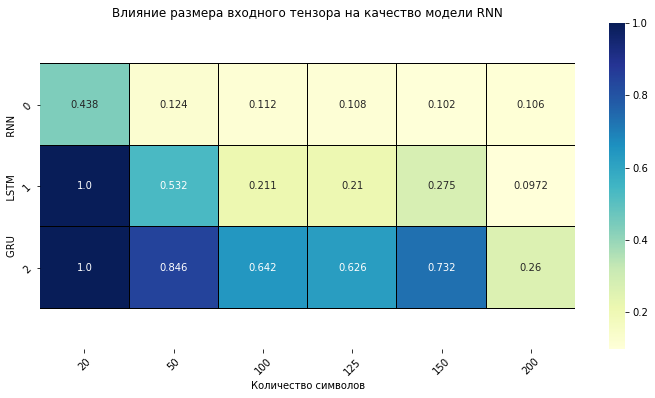

In [ ]:
s_l_list = [20,50,100,125,150,200]
df_ind   = [x.__name__ for x in rnn_list]

df_2  = pd.DataFrame(index = df_ind, columns = s_l_list)

for i in s_l_list:
    for rnn_type in rnn_list:
        model = rnn1(n_classes, embedding_size, hidden_size, num_layers, rnn_type).to(dev)
        opt   = tr.optim.Adam(model.parameters(), lr = 0.0015)
        crit  = tr.nn.CrossEntropyLoss()

        for iter in range(n_iters):
            model.train()
            x = tr.randint(n_classes, (batch_size, i)).to(dev)
            y = f(x)
            opt.zero_grad()
            pred = model(x)
            score = (y == pred.argmax(dim=-1)).sum() / t(y.shape).prod()
            loss = crit(pred.reshape(-1, n_classes), y.flatten()).to(dev)  #
            if loss < loss_best:
                model_best = copy.copy(model)
                loss_best = loss
            loss.backward()
            opt.step()

        model.eval()
        x = tr.randint(n_classes, (batch_size, i)).to(dev)
        y = f(x)
        pred = model(x).argmax(dim=-1)
        score = (y == pred).sum() / t(y.shape).prod()
        df_2.loc[rnn_type.__name__, i] = round(score.item(),5)

fine_table(df_2, title = 'Влияние размера входного тензора на качество модели RNN',
           x_l= 'Количество символов',
           y_l = 'GRU           LSTM            RNN')

Количество nn слоев

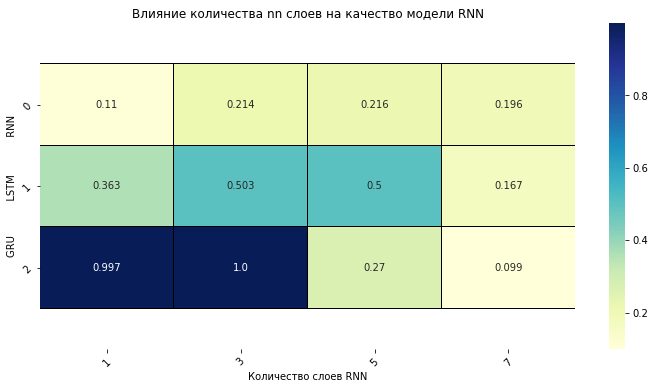

In [ ]:
seq_len  = 100
n_l_list = [1, 3, 5, 7]

df_1  = pd.DataFrame(index = df_ind, columns = n_l_list)


for i in n_l_list:
    for rnn_type in rnn_list:
        model = rnn1(n_classes, embedding_size, hidden_size, i, rnn_type).to(dev)
        opt   = tr.optim.Adam(model.parameters(), lr = 0.0015)
        crit  = tr.nn.CrossEntropyLoss()

        for iter in range(n_iters):
            model.train()
            x = tr.randint(n_classes, (batch_size, seq_len)).to(dev)
            y = f(x)
            opt.zero_grad()
            pred = model(x)
            score = (y == pred.argmax(dim=-1)).sum() / t(y.shape).prod()
            loss = crit(pred.reshape(-1, n_classes), y.flatten()).to(dev)  #
            if loss < loss_best:
                model_best = copy.copy(model)
                loss_best = loss
            loss.backward()
            opt.step()

        model.eval()
        x = tr.randint(n_classes, (batch_size, seq_len)).to(dev)
        y = f(x)
        pred = model(x).argmax(dim=-1)
        score = (y == pred).sum() / t(y.shape).prod()
        df_1.loc[rnn_type.__name__, i] = round(score.item(),5)

fine_table(df_1, title = 'Влияние количества nn слоев на качество модели RNN',
           x_l= 'Количество слоев RNN',
           y_l = 'GRU           LSTM            RNN')

Размер скрытого слоя

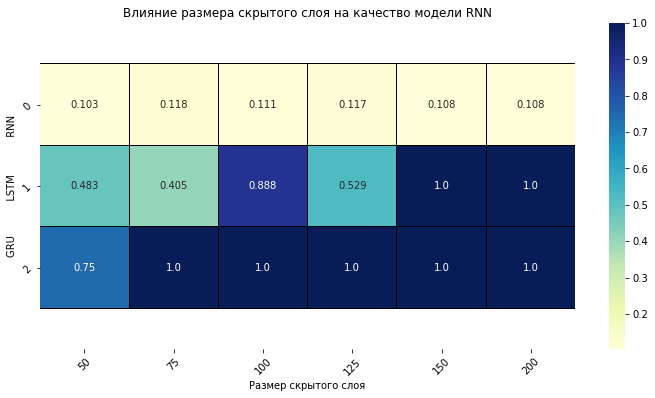

In [ ]:
num_layers     = 1
h_s_list       = [50,75,100,125,150,200]

df_4  = pd.DataFrame(index = df_ind, columns = h_s_list)

for i in h_s_list:
    for rnn_type in rnn_list:
        model = rnn1(n_classes, embedding_size, i, num_layers, rnn_type).to(dev)
        opt   = tr.optim.Adam(model.parameters(), lr = 0.0015)
        crit  = tr.nn.CrossEntropyLoss()

        for iter in range(n_iters):
            model.train()
            x = tr.randint(n_classes, (batch_size, seq_len)).to(dev)
            y = f(x)
            opt.zero_grad()
            pred = model(x)
            score = (y == pred.argmax(dim=-1)).sum() / t(y.shape).prod()
            loss = crit(pred.reshape(-1, n_classes), y.flatten()).to(dev)  #
            if loss < loss_best:
                model_best = copy.copy(model)
                loss_best = loss
            loss.backward()
            opt.step()

        model.eval()
        x = tr.randint(n_classes, (batch_size, seq_len)).to(dev)
        y = f(x)
        pred = model(x).argmax(dim=-1)
        score = (y == pred).sum() / t(y.shape).prod()
        df_4.loc[rnn_type.__name__, i] = round(score.item(),5)

fine_table(df_4, title = 'Влияние размера скрытого слоя на качество модели RNN',
           x_l= 'Размер скрытого слоя',
           y_l = 'GRU           LSTM            RNN')

Размер эмбеддинга

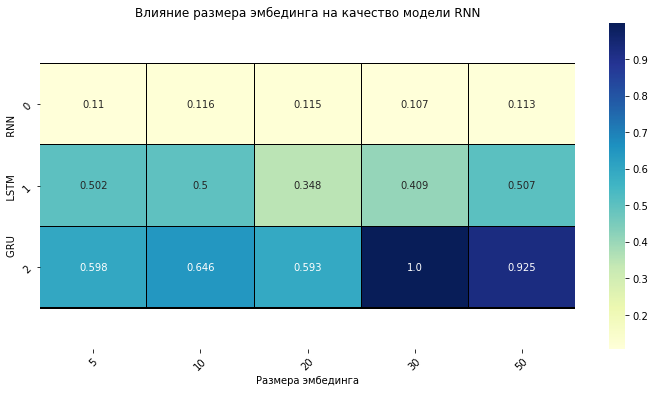

In [ ]:
hidden_size = 50
emb_s_list  = [5,10,20,30,50]

df_3  = pd.DataFrame(index = df_ind, columns = emb_s_list)

for i in emb_s_list:
    for rnn_type in rnn_list:
        model = rnn1(n_classes, i, hidden_size, num_layers, rnn_type).to(dev)
        opt   = tr.optim.Adam(model.parameters(), lr = 0.0015)
        crit  = tr.nn.CrossEntropyLoss()

        for iter in range(n_iters):
            model.train()
            x = tr.randint(n_classes, (batch_size, seq_len)).to(dev)
            y = f(x)
            opt.zero_grad()
            pred = model(x)
            score = (y == pred.argmax(dim=-1)).sum() / t(y.shape).prod()
            loss = crit(pred.reshape(-1, n_classes), y.flatten()).to(dev)  #
            if loss < loss_best:
                model_best = copy.copy(model)
                loss_best = loss
            loss.backward()
            opt.step()

        model.eval()
        x = tr.randint(n_classes, (batch_size, seq_len)).to(dev)
        y = f(x)
        pred = model(x).argmax(dim=-1)
        score = (y == pred).sum() / t(y.shape).prod()
        df_3.loc[rnn_type.__name__, i] = round(score.item(),5)

fine_table(df_3, title = 'Влияние размера эмбеддинга на качество модели RNN',
           x_l= 'Размера эмбединга',
           y_l = 'GRU           LSTM            RNN')

Размер скрытого слоя и количество слоев (только в LSTM)

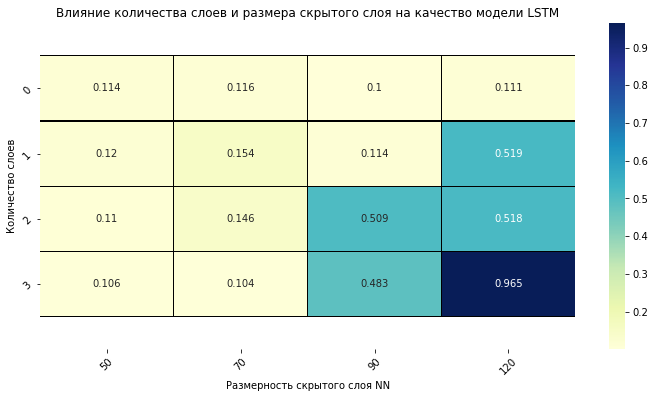

In [ ]:
h_s_list  = [50,70,90,120]
n_l_list  = [1,2,3,4]

df_5  = pd.DataFrame(index = n_l_list, columns = h_s_list)

for i in h_s_list:
    for j in n_l_list:
        model = rnn1(n_classes, embedding_size, i, j, tr.nn.GRU).to(dev)
        opt   = tr.optim.Adam(model.parameters(), lr = 0.0005)
        crit  = tr.nn.CrossEntropyLoss()

        for iter in range(n_iters):
            model.train()
            x = tr.randint(n_classes, (batch_size, seq_len)).to(dev)
            y = f(x)
            opt.zero_grad()
            pred = model(x)
            score = (y == pred.argmax(dim=-1)).sum() / t(y.shape).prod()
            loss = crit(pred.reshape(-1, n_classes), y.flatten()).to(dev)  #
            if loss < loss_best:
                model_best = copy.copy(model)
                loss_best = loss
            loss.backward()
            opt.step()

        model.eval()
        x = tr.randint(n_classes, (batch_size, seq_len)).to(dev)
        y = f(x)
        pred = model(x).argmax(dim=-1)
        score = (y == pred).sum() / t(y.shape).prod()
        df_5.loc[j, i] = round(score.item(),5)

fine_table(df_5, title = 'Влияние количества слоев и размера скрытого слоя на качество модели LSTM',
           x_l=  'Размерность скрытого слоя NN',
           y_l = 'Количество слоев')